# Identifying inappropriate TOSP code pairs.
The TOSP is an exhaustive list of surgical procedures eligible for MediSave/ MediaShield Life claims. Inappropriate TOSP claims occur when doctors submit  multiple TOSP codes for a surgical procedure that can be adequately described by a single code. As such, this notebook aims to analyze various machine learning models that can flag whenever a doctor submits TOSP codes that are similar to each other.

Since no labels are provided, the best course of action is to consider unsupervised learning models. The input data used will mainly be the "Descriptions" column of the dataset.

The following models will be analysed: DBSCAN and Agglomerative Clustering

In [251]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import time
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [252]:
# Download packages.
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Preprocessing data
The "S/N" and "Classification" columns were dropped as they do not seem to add any value to the classification for now. Punctuation was also filtered out and spaces were collapsed to ensure that there are only single spaces between words. <br><br>
Stop words are a set of commonly used words in a language such as "and", "the", "a", etc. Eliminating these stop words may improve computational efficiency as they add little to no significant value to the overall meaning of the sentence. Words also went through a lemmatization phase to ensure consistency.


In [253]:
class TOSPPreprocessor:
    def __init__(self):
        self.encode = OneHotEncoder(sparse_output=False)
        self.lemmatizer = WordNetLemmatizer()

    # Function to remove stop words.
    def remove_stopwords(self, description):
        stop_words = set(stopwords.words('english'))

        if isinstance(description, str):
            return ' '.join([word for word in description.split() if word.lower() not in stop_words])
        return description

    # Function to remove punctuation.
    def remove_punctuation(self, description):
        for word in description:
            if word in list(punctuation):
                description = description.replace(word, ' ')

        return description

    # Function for lemmatization.
    def lemmatize_words(self, description):

        # Splits the description into words and lemmatize each word.
        lemmatized_description = ' '.join([self.lemmatizer.lemmatize(word) for word in description.split()])

        return lemmatized_description

    # Collapse more than 1 space (due to removal of punctuation) into a single space.
    def trim_spaces(self, description):
        return re.sub(r'\s+', ' ', description).strip()

    # Get the first 2 characters in the Code column.
    def extract_code(self, code):
        return str(code)[:2]


    def preprocess_data_combined(self, df):

        # Drop unused columns.
        df.drop(columns=['S/N', 'Classification'], inplace=True)

        # Extract code.
        df['Category'] = df['Code'].apply(self.extract_code)
        # df['code_encoded'] = self.encode.fit_transform(df['Code'])


        df['Description'] = df['Description'].apply(self.remove_punctuation)
        df['Description'] = df['Description'].apply(self.trim_spaces)
        df['Description'] = df['Description'].apply(self.remove_stopwords)
        df['Description'] = df['Description'].apply(self.lemmatize_words)

        # Make description lower case.
        df['Description'] = df['Description'].str.lower()


        return df

Import the dataset and print details about it

In [254]:
category_dict = {"SA": "Integumentary",
                 "SB": "Musculoskeletal",
                 "SC": "Respiratory",
                 "SD": "Cardiovascular",
                 "SE": "Hemic & Lymphatic",
                 "SF": "Digestive",
                 "SG": "Urinary",
                 "SH": "Male Genital",
                 "SI": "Female Genital",
                 "SJ": "Endocrine",
                 "SK": "Nervous",
                 "SL": "Eye",
                 "SM": "ENT"}

# Import data.
df = pd.read_csv("combined_dataset.csv")
print(df.head())

# Print count of rows
print(df['Description'].size, "\n")

# Check for NaN values in any rows.
empty_values = (df.isna() | (df == '')).sum()
print(empty_values)


   S/N    Code  \
0    1  SA700B   
1    2  SA701B   
2    3  SA702B   
3    4  SA704B   
4    5  SA705B   

                                                           Description Table  \
0                       BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS   MSP   
1                  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)    3A   
2                 BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)    2C   
3  BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, SINGLE LESION    2B   
4    BREAST, LUMP (REMOVAL) WITH PARENCHYMAL FLAP CLOSURE (UNILATERAL)    4A   

      Classification  
0           Existing  
1           Existing  
2           Existing  
3           Existing  
4  Descriptor Change  
2363 

S/N               0
Code              0
Description       0
Table             0
Classification    0
dtype: int64


Make a copy of the original descriptions before preprocessing, then peform preprocessing of the Descriptions column.

In [255]:
# Make a copy of the original descriptions.
sentences = df['Description'].to_list()
df['original_description'] = df['Description'].copy()

# Peform preprocessing on the Descriptions column.
preprocessor = TOSPPreprocessor()
processed_data = preprocessor.preprocess_data_combined(df)
df = processed_data

print(df.head())

     Code                                                       Description  \
0  SA700B                        botulinum toxin therapy movement disorders   
1  SA701B                   breast ductal lesions microdochectomy bilateral   
2  SA702B                  breast ductal lesions microdochectomy unilateral   
3  SA704B  breast lumps imaging guided vacuum assisted biopsy single lesion   
4  SA705B           breast lump removal parenchymal flap closure unilateral   

  Table                                                 original_description  \
0   MSP                       BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS   
1    3A                  BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)   
2    2C                 BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)   
3    2B  BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, SINGLE LESION   
4    4A    BREAST, LUMP (REMOVAL) WITH PARENCHYMAL FLAP CLOSURE (UNILATERAL)   

  Category  
0       SA  
1       SA  
2    

In [256]:
# Use sentence transformer to encode the textual descriptions.
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(sentences)

# Defining functions to use for visualization and displaying test results

In [257]:
# Function to plot a 3D graph.
def plot_figure(embeddings_reduced, df_original_descr, plot_title, color_map=None):
  fig = go.Figure()

  fig.add_trace(go.Scatter3d(
      x=embeddings_reduced[:, 0],
      y=embeddings_reduced[:, 1],
      z=embeddings_reduced[:, 2],
      mode='markers',
      marker=dict(
          size=5,
          color = 'blue' if color_map is None else color_map,
          opacity=0.8
      ),
      text=df_original_descr, # Hover text
      hoverinfo="text",  # Display only the text on hover
  ))


  fig.update_layout(
      title=plot_title,
      scene=dict(

          xaxis_title="PC1",
          yaxis_title="PC2",
          zaxis_title="PC3"
      ),

  )

  fig.show()


# Function to test a whole dataset (more than 2 rows).
pd.set_option('display.max_colwidth', None)
def test_df_tosp(test_csv, tosp_labels_df):
  inappr_counter = 0
  test_df = pd.read_csv(test_csv)

  rows = tosp_labels_df[tosp_labels_df["Code"].isin(test_df["Code"])]

  for i in range(0, len(rows)):
      for j in range(i + 1, len(rows)):
          if (rows["Labels"].iloc[i] == rows["Labels"].iloc[j]):
            print(f"{rows['original_description'].iloc[i]}\n{rows['original_description'].iloc[j]}\n")
            print(f"Inappropriate code pair detected: {rows['Code'].iloc[i]} and {rows['Code'].iloc[j]}\n")
            inappr_counter += 1

  print(f"Total inappropriate pairs: {inappr_counter}")


# Function to test a csv file with only 2 rows.
def test_case_tosp(test_csv, tosp_labels_df):
  test_df = pd.read_csv(test_csv)

  rows = tosp_labels_df[tosp_labels_df["Code"].isin(test_df["Code"])]


  if (rows["Labels"].iloc[0] == rows["Labels"].iloc[1]):
    print(f"{rows['original_description'].iloc[0]}\n{rows['original_description'].iloc[1]}\n")
    print(f"Inappropriate code pair detected: {rows['Code'].iloc[0]} and {rows['Code'].iloc[1]}\n")

  else:
    print(f"{rows['original_description'].iloc[0]}\n{rows['original_description'].iloc[1]}\n")
    print("Valid code pair.\n")

# Reducing dimension for visualizing the dataset

In [258]:
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(embeddings)

plot_figure(reduced_embeddings, df["original_description"], "Dataset Visualization", color_map=None)

# Agglomerative Clustering

The starting value of the n_values range is selected with domain knowledge as worst case scenario, every point is clustered with at most one other point which brings us to estimate that there should be at least 1000 clusters.

# Finding the best n_clusters value

Time taken: 50.46752715110779s


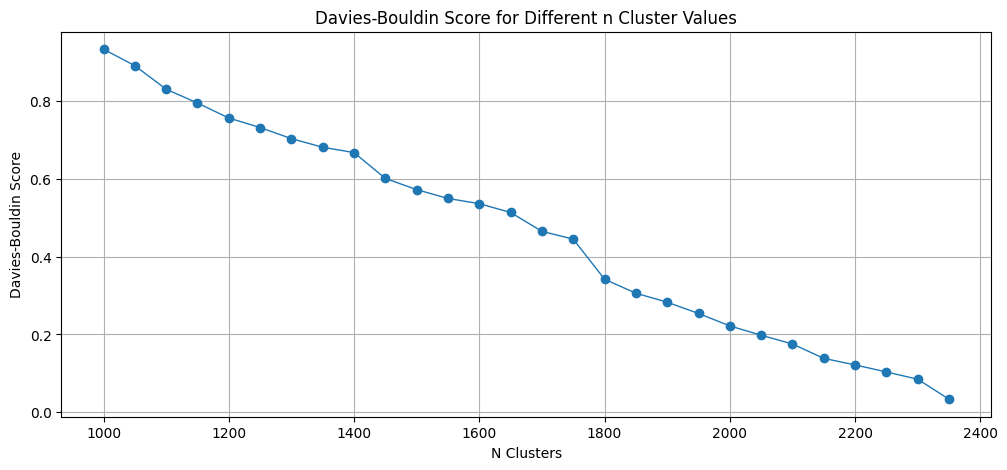

In [259]:
dbi_history = []
n_values = np.arange(1000, df.shape[0], 50)

start_time = time.time()
for n in n_values:
  agg_clf = AgglomerativeClustering(n_clusters=n, linkage='single', metric='cosine')
  agg_clf.fit(embeddings)

  score = davies_bouldin_score(embeddings, agg_clf.labels_)

  dbi_history.append(score)

print(f"Time taken: {(time.time() - start_time)}s")
plt.figure(figsize=(12, 5))

plt.plot(n_values, dbi_history, 'o', ls='-', lw=1)
plt.title(f"Davies-Bouldin Score for Different n Cluster Values")
plt.xlabel("N Clusters")
plt.ylabel("Davies-Bouldin Score")

plt.grid()
plt.show()

Based on domain knowledge and also to prevent overfitting, values after 2000 will not be used. There is a steep drop in the Davies-Boudlin Score around 1800, meaning that the separation is better than all the N cluster values before. The values after 1800 proceed to decrease at a steady rate but should also indicate overfitting. Hence, 1800 clusters will be used to feed the Agglomerative Clustering model.

In [260]:
from scipy.cluster.hierarchy import dendrogram, linkage
start_time = time.time()
agg_clf = AgglomerativeClustering(n_clusters=1800, linkage='single', metric='cosine')
predictions = agg_clf.fit_predict(embeddings)

df["Labels"] = predictions
print(f"Time taken: {(time.time() - start_time)}s")
print("Total number of unique labels:",df["Labels"].nunique())



Time taken: 0.8110918998718262s
Total number of unique labels: 1800


In [261]:
test_df_tosp("combined_dataset.csv", df)

# Create a color mapping based on unique labels
unique_labels = df["Labels"].unique()
eye_color_map = {label: f"rgb({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)})" for label in unique_labels}
df["color"] = df["Labels"].map(eye_color_map)

plot_figure(embeddings, df["Labels"].astype(str) + ": " + df["original_description"], "Clustering Visualization", color_map=df["color"])

BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)
BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)

Inappropriate code pair detected: SA701B and SA702B

BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, SINGLE LESION
BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, > 1 LESIONS

Inappropriate code pair detected: SA704B and SA706B

BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH SENTINEL NODE BIOPSY/ AXILIARY NODE SAMPLING
BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH AXILIARY CLEARANCE, WITH/WITHOUT SENTINEL NODE BIOPSY

Inappropriate code pair detected: SA707B and SA823B

BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH SENTINEL NODE BIOPSY/ AXILIARY NODE SAMPLING
BREAST TUMOUR (MALIGNANT, VARIOUS LESIONS), SIMPLE MASTECTOMY WITH AXILLARY CLEARANCE, WITH/WITHOUT SENTINEL NODE BIOPSY

Inappropriate code pair detected:

The labels are tested on a subset of the original dataset, SJ_Endocrine.csv was used as it is managable with 15 rows. At a glance, these are some inappropriate TOSP codes within the dataset: <br>

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY<br>
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (UNILATERAL)<br>
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)<br>
THYROID, VARIOUS LESIONS, TOTAL THYROIDECTOMY, COMPLEX (RECURRENCE), WITH/WITHOUT STERNAL SPLIT<br>
THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY<br>


The model only managed to detect 2 pairs of invalid TOSP codes and it missed quite a number of similar TOSP codes, indicating low accuracy.

In [262]:
test_df_tosp("SJ_Endocrine.csv", df)


PARATHYROID, VARIOUS LESIONS, EXCISION
PARATHYROID, VARIOUS LESIONS, RE EXPLORATION

Inappropriate code pair detected: SJ800P and SJ801P

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (UNILATERAL)

Inappropriate code pair detected: SJ703T and SJ804T

Total inappropriate pairs: 2


# Evaluating model against test cases
The agglomerative clustering model is assessed against 7 different test cases, with the first 5 being inappropriate code pairs. The test code pairs chosen have varying levels of difference in their description which will gauge how well the model detects similarities.



> Test 1 Pair: 1 word difference, same length (MAJOR, MINOR) -> **INVALID** <br>
SA711S: SOFT TISSUE (LOWER LIMB), CONTRACTURE, MAJOR RELEASE <br>
SA712S: SOFT TISSUE (LOWER LIMB), CONTRACTURE, MINOR RELEASE <br>

<br>

> Test 2 Pair: 1 word difference, different length (BILATERAL) -> **INVALID** <br>
SL701L: LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY <br>
SL702L: LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL <br>

<br>

> Test 3 Pair: 2 word difference, different length (BILATERAL, UNILATERAL LEFT) -> **INVALID**  <br>
SL807L: LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (BILATERAL) <br>
SL808L: LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (UNILATERAL LEFT) <br>

<br>

> Test 4 Pair: 2 word difference, same length (BONE GRAFT, ALLOPLASTIC MATERIAL)  -> **INVALID** <br>
SL809O: ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH BONE GRAFT <br>
SL810O: ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH ALLOPLASTIC MATERIAL <br>

<br>




> Test 5 Pair: 3 word difference, different length (WITH BLOCK NECK DISSECTION)  -> **INVALID** <br>
SM712L: LARYNX, TUMOR, PARTIAL LARYNGECTOMY <br>
SM713L: LARYNX, TUMOR, PARTIAL LARYNGECTOMY WITH BLOCK NECK DISSECTION <br>

<br>



> Test 6 Pair: Valid code pair, sufficiently different words with different meanings  -> **VALID** <br>
SM818E: EAR, MICROTIA, CREATION OF POST-AURICULAR SULCUS WITH SKIN GRAFT <br>
SM819E: EAR, MICROTIA, INSERTION OF CARTILAGE/SILASTIC FRAMEWORK <br>

<br>




> Test 7 Pair: Valid code pair, sufficiently different words with different meanings  -> **VALID** <br>
SB716F: FOOT, CONGENITAL TALIPES EQUINOVARUS (CTEV), BILATERAL RELEASE <br>
SB725F: FOOT, ONE BONE OSTEOTOMY WITH SOFT TISSUE RELEASE, CUBOID <br>


# Results
Both the valid TOSP test cases passed. However, out of the 5 inappropriate TOSP test cases, 3 were correctly identified, with  test cases failing to correctly detect an inappropriate pair even with a word difference of as low as 2, indicating poor result from the model.

Particularly, the model works well in detecting similar TOSP codes if the word difference in the description of the procedure is less than about 2 words for decriptions with different word lenths. For descriptions with slight differences but the same length, the model may miss it. This can be seen in test case 4 where despite being largely similar at the front, the model still considers them as separate due to 2 different words at the end, which is not very accurate.



In [263]:
test_case_tosp("test1.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test2.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test3.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test4.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test5.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test6.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test7.csv", df)
print("--------------------------------------------------------------------------------------------------")

SOFT TISSUE (LOWER LIMB), CONTRACTURE, MAJOR RELEASE
SOFT TISSUE (LOWER LIMB), CONTRACTURE, MINOR RELEASE

Inappropriate code pair detected: SA711S and SA712S

--------------------------------------------------------------------------------------------------
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL

Inappropriate code pair detected: SL701L and SL702L

--------------------------------------------------------------------------------------------------
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (BILATERAL)
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (UNILATERAL LEFT)

Inappropriate code pair detected: SL807L and SL808L

--------------------------------------------------------------------------------------------------
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH BONE GRAFT
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH ALLOPLASTIC MATERIAL

# ------------------------------------------------------------------------

# DBSCAN

The fine tuning of the DBSCAN hyperparameters compromises of finding the best epsilon and minimum points value (MinPts). For epsilon, as range of values from 0.1 to 0.5 was usedThese values will be used to test:

epsilon_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5] <br>
min_points_values = [1, 2, 3, 5, 7, 9]<br>

<br>To evaluate the quality of the clustering, the Davies-Bouldin index was utilized due to its ability to work with any amount of clusters.

A high the Davies-Bouldin score indicates that the epsilon and MinPts pair results in bad clustering.


From the heatmap, we can see that the best epsilon and MinPts values, according to the Davies-Bouldin score, is 0.1 and 1 respectively. Despite that, the value of the epsilon is rather low, which could potentially affect the accuracy of the clustering by letting invalid TOSP codes pairs go undetected unless they are extremely similar to each other.

In [264]:
epsilon_values = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
min_points_values = [1, 2, 3, 5, 7, 9]
best_dbi_score = float('inf')
best_ch_score = -1
best_min_points = 0
best_epsilon = 0
best_clustering = None
history_dbi = []
history_chs = []

start_time = time.time()
for min_points in min_points_values:
    for epsilon in epsilon_values:
        clf = DBSCAN(eps=epsilon, min_samples=min_points, metric='cosine')
        prediction = clf.fit_predict(embeddings)

        unique_labels = set(prediction) - {-1}
        num_clusters = len(unique_labels)

        if num_clusters > 1:
            ch_score = calinski_harabasz_score(embeddings, prediction) # Higher better
            dbi_score = davies_bouldin_score(embeddings, prediction) # Lower better
        else:
            dbi_score = float('inf')
            ch_score = -1

        # print(f"MinPts: {min_points}, Epsilon: {epsilon}, Davies Bouldin Score: {score}")
        history_dbi.append(dbi_score)
        history_chs.append(ch_score)

        if (dbi_score < best_dbi_score) and (ch_score > best_ch_score):
            best_dbi_score = dbi_score
            best_ch_score = ch_score
            best_min_points = min_points
            best_clustering = prediction
            best_epsilon = epsilon

print(f"Time taken: {(time.time() - start_time)}s")
print(f"\nBest MinPts: {best_min_points}, Best Epsilon {best_epsilon}, Best Davies Bouldin Score: {best_dbi_score}, Best Calinski-Harabasz Index Score: {best_ch_score}")




Time taken: 14.736865043640137s

Best MinPts: 1, Best Epsilon 0.1, Best Davies Bouldin Score: 0.350893983072987, Best Calinski-Harabasz Index Score: 18.92917666654028


The best epsilon value is 0.1, which is quite small and may cause many points to be assigned to its own cluster which can overfit a model.

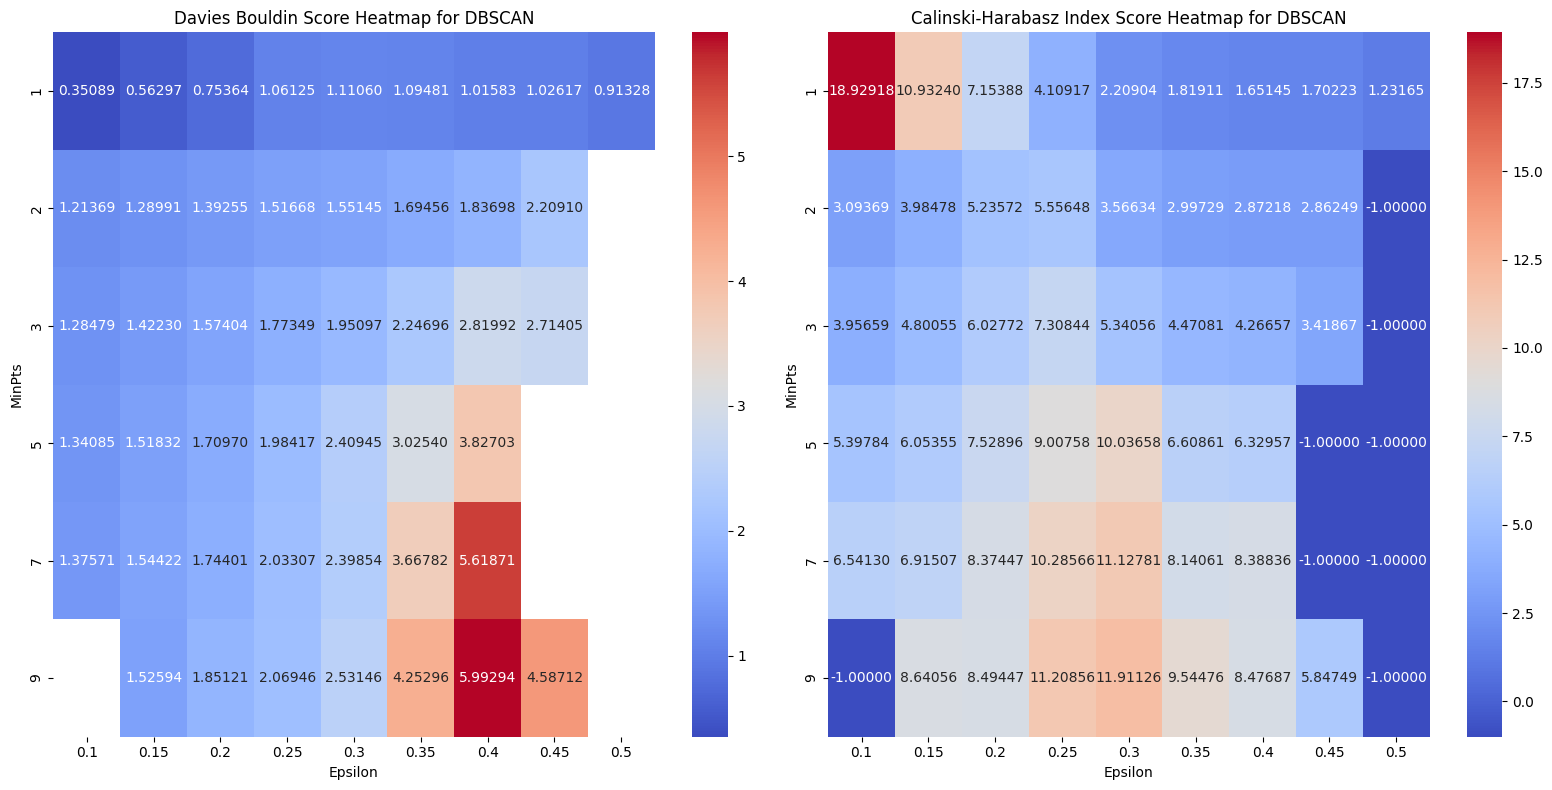

In [265]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
scores_grid = np.array(history_dbi).reshape(len(min_points_values), len(epsilon_values))
scores_grid = np.where(np.isinf(scores_grid), np.nan, scores_grid)

# Davies Bouldin Score
sns.heatmap(scores_grid, annot=True, fmt=".5f", cmap="coolwarm", xticklabels=epsilon_values, yticklabels=min_points_values)

plt.xlabel("Epsilon")
plt.ylabel("MinPts")
plt.title("Davies Bouldin Score Heatmap for DBSCAN")

# Calinski-Harabasz Index Score
plt.subplot(1, 2, 2)
scores_grid = np.array(history_chs).reshape(len(min_points_values), len(epsilon_values))

sns.heatmap(scores_grid, annot=True, fmt=".5f", cmap="coolwarm", xticklabels=epsilon_values, yticklabels=min_points_values)

plt.xlabel("Epsilon")
plt.ylabel("MinPts")
plt.title("Calinski-Harabasz Index Score Heatmap for DBSCAN")
plt.tight_layout()
plt.show()


# Training DBSCAN Model



In [266]:
start_time = time.time()
clf = DBSCAN(eps=best_epsilon, min_samples=best_min_points, metric='cosine')
prediction = clf.fit_predict(embeddings)

df["Labels"] = prediction
print(f"Time taken: {(time.time() - start_time)}s")
print("Total number of unique labels:",df["Labels"].nunique())


Time taken: 0.14304900169372559s
Total number of unique labels: 1780


# Evaluating DBSCAN Model


Similar to agglomerative clustering, the model fails to detect a number of inappropriate pairs.

# Results (eps = 0.1, MinPts = 1)

In [267]:
test_df_tosp("combined_dataset.csv", df)

BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)
BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)

Inappropriate code pair detected: SA701B and SA702B

BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, SINGLE LESION
BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, > 1 LESIONS

Inappropriate code pair detected: SA704B and SA706B

BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH SENTINEL NODE BIOPSY/ AXILIARY NODE SAMPLING
BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH AXILIARY CLEARANCE, WITH/WITHOUT SENTINEL NODE BIOPSY

Inappropriate code pair detected: SA707B and SA823B

BREAST, TUMOR (MALIGNANT), WIDE EXCISION/ LUMPECTOMY/SEGMENTAL MASTECTOMY/ PARTIAL MASTECTOMY, WITH SENTINEL NODE BIOPSY/ AXILIARY NODE SAMPLING
BREAST TUMOUR (MALIGNANT, VARIOUS LESIONS), SIMPLE MASTECTOMY WITH AXILLARY CLEARANCE, WITH/WITHOUT SENTINEL NODE BIOPSY

Inappropriate code pair detected:

# Evaulating the model on test cases

The results for the test cases for this DBSCAN model are similar to the results of the agglomerative model. The same 3 out of 5 inappropriate TOSP codes were detected.

In [268]:
test_case_tosp("test1.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test2.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test3.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test4.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test5.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test6.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test7.csv", df)
print("--------------------------------------------------------------------------------------------------")

SOFT TISSUE (LOWER LIMB), CONTRACTURE, MAJOR RELEASE
SOFT TISSUE (LOWER LIMB), CONTRACTURE, MINOR RELEASE

Inappropriate code pair detected: SA711S and SA712S

--------------------------------------------------------------------------------------------------
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL

Inappropriate code pair detected: SL701L and SL702L

--------------------------------------------------------------------------------------------------
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (BILATERAL)
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (UNILATERAL LEFT)

Inappropriate code pair detected: SL807L and SL808L

--------------------------------------------------------------------------------------------------
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH BONE GRAFT
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH ALLOPLASTIC MATERIAL

# Results (eps = 0.15, MinPts = 1)

Since it seems to not detect descriptions with about 2 or more words despite being invalid, we will increase the epsilon by 0.05.

More test cases passed now (6 out of 7) but the model occasionally detects different procedures that are different (false positives), for example: <br>


(tested on SL_Eye.csv)
> EYE, GLAUCOMA, FILTERING AND ALLIED OPERATIONS AND CATARACT SURGERY, WITH OR WITHOUT INTRAOCULAR LENS IMPLANT <br>
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (UNILATERAL LEFT) <br>



In [269]:
start_time = time.time()
clf = DBSCAN(eps=0.15, min_samples=1, metric='cosine')
prediction = clf.fit_predict(embeddings)

df["Labels"] = prediction
print(f"Time taken: {(time.time() - start_time)}s")
print("Total number of unique labels:",df["Labels"].nunique())

Time taken: 0.12149453163146973s
Total number of unique labels: 1534


In [270]:
test_df_tosp("SJ_Endocrine.csv", df)

PARATHYROID, VARIOUS LESIONS, EXCISION
PARATHYROID, VARIOUS LESIONS, RE EXPLORATION

Inappropriate code pair detected: SJ800P and SJ801P

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY

Inappropriate code pair detected: SJ703T and SJ802T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY

Inappropriate code pair detected: SJ703T and SJ803T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (UNILATERAL)

Inappropriate code pair detected: SJ703T and SJ804T

THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY

Inappropriate code pair detected: SJ802T and SJ803T

THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL

In [271]:
test_df_tosp("SL_Eye.csv", df)

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT

Inappropriate code pair detected: SL700B and SL701B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL

Inappropriate code pair detected: SL700B and SL702B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, DIRECT BROWPLASTY, BILATERAL

Inappropriate code pair detected: SL700B and SL703B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, DIRECT BROWPLASTY, UNILATERAL

Inappropriate code pair detected: SL700B and SL704B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT
BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL

Inappropriate code pair detected: SL701B and SL702B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT
BROW, DIRECT BROWPLASTY, BILATERAL

Inappropriate code pair detected: SL701B and SL703B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT
BROW, DIRECT BROWPLASTY, UNILATERAL

Inappropriate code pair detected: SL701B and SL704B

BROW, BROWLIFT, EN

In [272]:
test_case_tosp("test1.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test2.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test3.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test4.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test5.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test6.csv", df)
print("--------------------------------------------------------------------------------------------------")

test_case_tosp("test7.csv", df)
print("--------------------------------------------------------------------------------------------------")

SOFT TISSUE (LOWER LIMB), CONTRACTURE, MAJOR RELEASE
SOFT TISSUE (LOWER LIMB), CONTRACTURE, MINOR RELEASE

Inappropriate code pair detected: SA711S and SA712S

--------------------------------------------------------------------------------------------------
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY
LENS, CATARACT (PAEDIATRIC), EXTRACTION WITH ANTERIOR VITRECTOMY - BILATERAL

Inappropriate code pair detected: SL701L and SL702L

--------------------------------------------------------------------------------------------------
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (BILATERAL)
LENS, CATARACT, EXTRACTION WITH INTRA-OCULAR LENS IMPLANT (UNILATERAL LEFT)

Inappropriate code pair detected: SL807L and SL808L

--------------------------------------------------------------------------------------------------
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH BONE GRAFT
ORBIT, VARIOUS LESIONS, RECONSTRUCTION OF FLOOR/ROOF WITH ALLOPLASTIC MATERIAL

# Training Agglomerative Clustering Model on Individual Datasets

In [273]:
def test_agg_model(dataset_csv, test_start, test_step):
  df = pd.read_csv(dataset_csv)
  sentences = df['Description'].to_list()

  df['original_description'] = df['Description'].copy()

  # Peform preprocessing on the Descriptions column.
  preprocessor = TOSPPreprocessor()
  processed_data = preprocessor.preprocess_data_combined(df)
  df = processed_data

  model = SentenceTransformer('all-MiniLM-L6-v2')
  embeddings = model.encode(sentences)

  dbi_history = []
  n_values = np.arange(test_start, df.shape[0], test_step)

  for n in n_values:
    agg_clf = AgglomerativeClustering(n_clusters=n, linkage='single', metric='cosine')
    agg_clf.fit(embeddings)

    score = davies_bouldin_score(embeddings, agg_clf.labels_)

    dbi_history.append(score)

  plt.figure(figsize=(12, 5))

  plt.plot(n_values, dbi_history, 'o', ls='-', lw=1)
  plt.title(f"Davies-Bouldin Score for Different n Cluster Values")
  plt.xlabel("N Clusters")
  plt.ylabel("Davies-Bouldin Score")

  plt.grid()
  plt.show()

  return df, embeddings

def train_model(df, embeddings, n_clusters):
  agg_clf = AgglomerativeClustering(n_clusters=n_clusters, linkage='single', metric='cosine')
  predictions = agg_clf.fit_predict(embeddings)

  df["Labels"] = predictions
  print("Total number of unique labels:", df["Labels"].nunique())

  return df

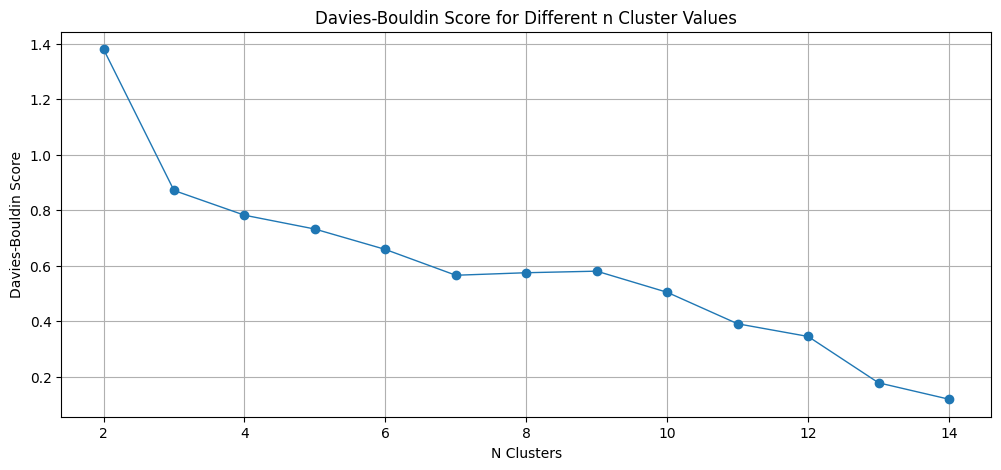

In [274]:
df_embeddings = test_agg_model("SJ_Endocrine.csv", 2, 1)

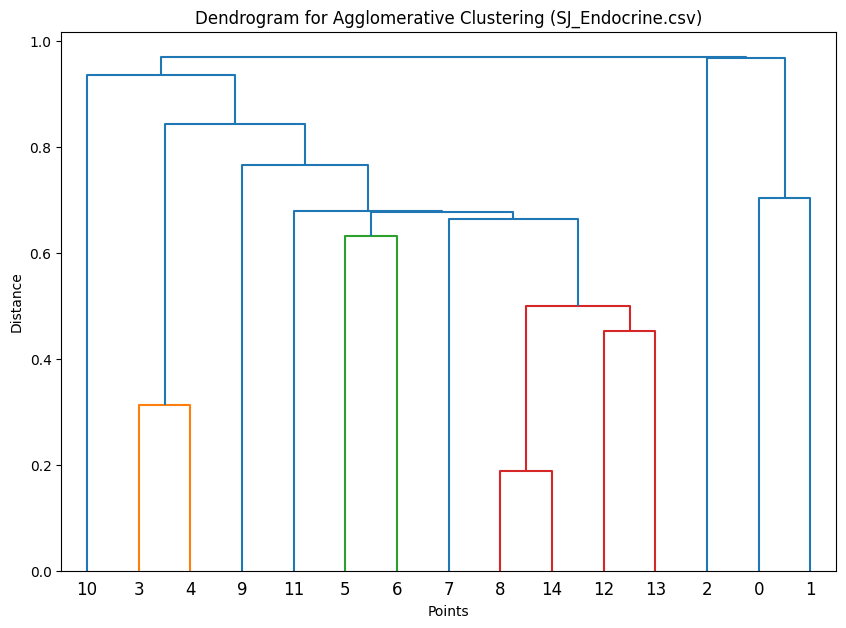

In [275]:
linked = linkage(df_embeddings[1], method='single')

plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.66)

plt.title("Dendrogram for Agglomerative Clustering (SJ_Endocrine.csv)")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

Based on the dendogram and the DBI score, it seems that the n_clusters value of 10 is the most suitable for this dataset.

In [276]:
df_result = train_model(df_embeddings[0], df_embeddings[1], 10)
test_df_tosp("SJ_Endocrine.csv", df_result)

Total number of unique labels: 10
PARATHYROID, VARIOUS LESIONS, EXCISION
PARATHYROID, VARIOUS LESIONS, RE EXPLORATION

Inappropriate code pair detected: SJ800P and SJ801P

THYROID, VARIOUS LESIONS, NEEDLE BIOPSY
THYROID, VARIOUS LESIONS, IMAGING GUIDED PERCUTANEOUS ASPIRATION/BIOPSY

Inappropriate code pair detected: SJ700T and SJ701T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY

Inappropriate code pair detected: SJ703T and SJ802T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY

Inappropriate code pair detected: SJ703T and SJ803T

THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (BILATERAL)
THYROID, VARIOUS LESIONS, TOTAL/SUBTOTAL THYROIDECTOMY WITH NECK DISSECTION (UNILATERAL)

Inappropriate code pair detected: SJ703T and SJ804T

THYROID, VARIOUS LESIONS, 

In [277]:
unique_labels = df_result["Labels"].unique()
eye_color_map = {label: f"rgb({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)})" for label in unique_labels}
df_result["color"] = df_result["Labels"].map(eye_color_map)

plot_figure(df_embeddings[1], df_result["Labels"].astype(str) + ": " + df_result["original_description"], "Clustering Visualization", color_map=df_result["color"])

Just by examining the plot, the model has slight inaccuracies, with
"THYROID, VARIOUS LESIONS, TOTAL THYROIDECTOMY, COMPLEX (RECURRENCE), WITH/WITHOUT STERNAL SPLIT" not clustered together with other THYROIDECTOMY procedures. This could be due to the result of the vectorization of the textual descriptions, it is placed far from the other similar procedures, but overall the model performs decently.



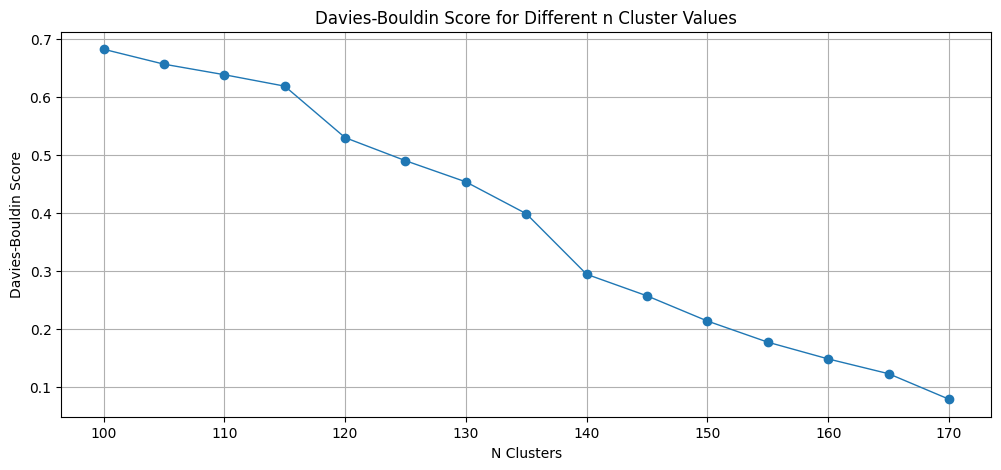

In [278]:
df_embeddings = test_agg_model("SL_Eye.csv", 100, 5)

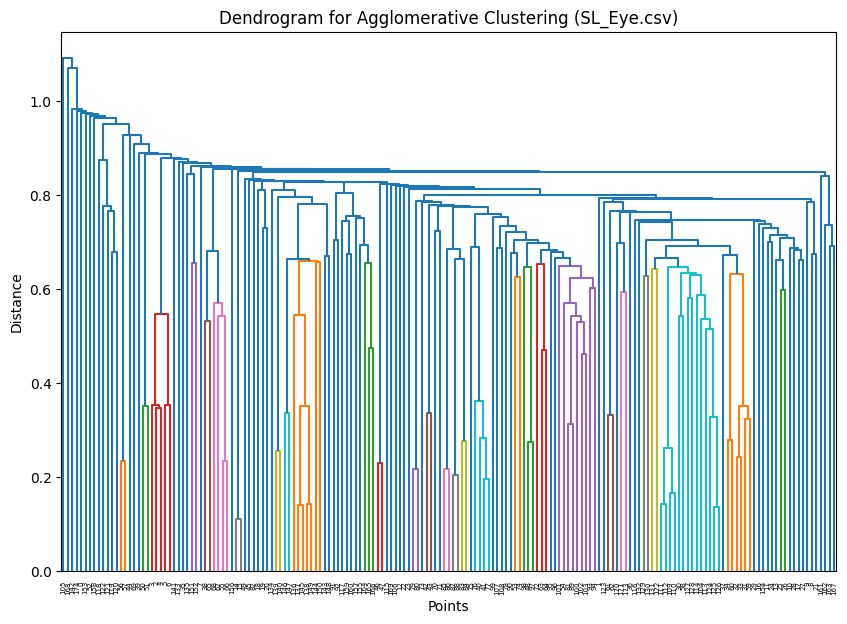

In [279]:
linked = linkage(df_embeddings[1], method='single')

plt.figure(figsize=(10, 7))
dendrogram(linked, color_threshold=0.66)

plt.title("Dendrogram for Agglomerative Clustering (SL_Eye.csv)")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

Supplemented by the dendogram, the optimal n_clusters value is about 140

In [280]:
df_result_endo = train_model(df_embeddings[0], df_embeddings[1], 140)

test_df_tosp("SL_Eye.csv", df_result_endo)

Total number of unique labels: 140
BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT

Inappropriate code pair detected: SL700B and SL701B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL
BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL

Inappropriate code pair detected: SL700B and SL702B

BROW, BROWLIFT, ENDOSCOPIC, BILATERAL WITH MID- FACE LIFT
BROW, BROWLIFT, ENDOSCOPIC, UNILATERAL

Inappropriate code pair detected: SL701B and SL702B

BROW, DIRECT BROWPLASTY, BILATERAL
BROW, DIRECT BROWPLASTY, UNILATERAL

Inappropriate code pair detected: SL703B and SL704B

CORNEAL/OCULAR SURFACE, OSTEO-ODONTO- KERATOPROSTHESIS STAGE 1
CORNEAL/OCULAR SURFACE, OSTEO-ODONTO- KERATOPROSTHESIS STAGE 2

Inappropriate code pair detected: SL706C and SL707C

EYE, GLAUCOMA, GONIOTOMY/TRABECULOTOMY (BILATERAL)
EYE, GLAUCOMA, GONIOTOMY/TRABECULOTOMY (BILATERAL) - PAEDIATRIC

Inappropriate code pair detected: SL701E and SL702E

EYE, GLAUCOMA, GONIOTOMY/TRABECULOTOMY (BILATERAL)
EYE, GLA

In [281]:
unique_labels = df_result_endo["Labels"].unique()
eye_color_map = {label: f"rgb({np.random.randint(0, 255)}, {np.random.randint(0, 255)}, {np.random.randint(0, 255)})" for label in unique_labels}
df_result_endo["color"] = df_result_endo["Labels"].map(eye_color_map)

plot_figure(df_embeddings[1], df_result_endo["Labels"].astype(str) + ": " + df_result_endo["original_description"], "Clustering Visualization", color_map=df_result_endo["color"])

# Conclusion

In this notebook, the DBSCAN and Agglomerative model was explored to solve the problem of clustering TOSP codes in order to flag inappropriate pairs when a claim is submitted.

## Rationale of using the DBSCAN
DBSCAN was used as the number of clusters do not need to be specified beforehand. Agglomerative Clustering was consider as it is a heirarchical clustering method and


## Accuracy
Both the DBSCAN and Agglomerative Clustering models can capture descriptions that have at most 1 or 2 different words with different lengths. When the DBSCAN epsilon value was increased to 0.25, the model is able to detect descriptions with higher difference in words, but also may cause some valid pairs to be clustered together for having similar phrases despite being 2 totally different procedures. This may be attributed to not being able to capture the semantics of the descriptions such as the following: <br>

THYROID, VARIOUS LESIONS, NEEDLE BIOPSY <br>
THYROID, VARIOUS LESIONS, HEMITHYROIDECTOMY/PARTIAL THYROIDECTOMY <br>

Since they have the exact same starting words, the model incorrectly clustered them together as the embeddings dictate them as being close to each other.

## Model Size
## Computation Speed in Training and Testing

*   Agglomerative Clustering<br>
For working on the entire combined dataset, finding the best n_clusters value for agglomerative clustering takes about 51 seconds while the time taken to actual training after finding a suitable value is around 0.8s. The range of values used to test ranges from 1000 to 2364 (total number of rows), with an increment of 50 each step

*   DBSCAN<br>
Given the 2 lists of 9 epsilon and 6 MinPts values to test on, the DBSCAN model testing takes approximately 13s to calculate the Davies Bouldin score to find the best epsilon and MinPts. The training of the model with the epsilon and MinPts values found takes about 0.12s

Overall, both models presented good performances as it does not take much computational resources or time in training or testing the models and both models also produce similar results, with DBSCAN being slightly more sensitive to similar descriptions when 0.15 is used as an epsilon instead of 0.1.


With a value of 0.1 and 0.15, the DBSCAN model produces relatively decent accuracy on TOSP code pairs that are submitted with both BILATERAL and UNILATERAL/ MULTIPLE and SINGLE or description pairs whose difference is just a modifier with a few words. Increasing the epsilon to 0.15 passes more of the 7 chosen test cases, but further testing proved that false positives happen more frequently.

Hence, this model could be used to spot inappropriate TOSP code pairs that  


 modifiers
extremely similar to each other in certain cases.
